In [1]:
!pip install -U accelerate bitsandbytes

# Naive 8-bit Quantization

- absolute maximum (absmax) quantization
- zero-point quantization (asymmetric)

In both cases, the goal is to map an FP32 tensor $\mathbf{X}$ to an INT8 tensor $\mathbf{X}_\text{quant}$.

With **absmax quantization**, the original number is divided by the absolute maximum value of the tensor and multiplied by a scaling factor (127) to map inputs into the range [-127, 127]. To retrieve the original FP16 values, the INT8 number is divided to the quantization factor, acknowledging some loss of precision due to rounding.

$$\mathbf{X}_\text{quant} = \text{round}\left(\frac{127}{\max|\mathbf{X}|}\cdot\mathbf{X}\right)$$

$$\mathbf{X}_\text{dequant} = \frac{\max|\mathbf{X}|}{127}\cdot\mathbf{X}_\text{quant}$$

For instance, let's say we have an absolution maximum value of 3.2. A weight of 0.1 would be quantized to $\text{round}(0.1 \times \frac{127}{3.2}) = 4$. If we want to dequantize it, we would get $4 / \frac{127}{3.2} = 0.1008$, which implies an error of 0.0008. Here's the corresponding Python implementation:

In [3]:
import torch

def absmax_quantize(X):
    # calculate scale
    scale = 127 / torch.max(torch.abs(X))
    # quantize
    X_quant = (scale * X).round()
    # dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

In [4]:
X = torch.Tensor([3.2, -3.0, 0.1])
absmax_quantize(X)

(tensor([ 127, -119,    4], dtype=torch.int8),
 tensor([ 3.2000, -2.9984,  0.1008]))

With **zero-point quantization**, we can consider asymmetric input distributions, which is useful when you consider the output of a ReLU function for example. The input values are first scaled by the total range of values (255) divided by the difference between the maximum and minimum values. This distribution is then shifted by the zero-point to map it into the range [-128, 127]. First, we calculate the scale factor and the zero-point value:

$$\text{scale} = \frac{255}{\max(\mathbf{X}) - \min(\mathbf{X})}$$

$$\text{zeropoint} = -\text{round}(\text{scale}\cdot\min(\mathbf{X})) - 128$$

Then, we can use these variables to quantize or dequantize our weights:

$$\mathbf{X}_\text{quant} = \text{round}\left(\text{scale}\cdot\mathbf{X} + \text{zeropoint}\right)$$

$$\mathbf{X}_\text{dequant} = \frac{\mathbf{X}_\text{quant} - \text{zeropoint}}{\text{scale}}$$

Let's take an example: we have a maximum value of 3.2 and a minimum value of -3.0. We can calculate the scale is $\frac{255}{3.2 + 3.0} = 41.13$ and zero-point $-\text{round}(41.13\cdot -3.0) - 128 = 123 - 128 = -5$, so our previous weight of 0.1 would be quantize to $\text{round}(41.13\cdot 0.1 - 5) = -1$. This is very different from the previous value obtained using absmax (4 vs. -1).

The Python implementation is quite straightforward:

In [5]:
def zeropoint_quantize(X):
    # calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # calculate scale
    scale = 255 / x_range

    # shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    # scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant

In [6]:
zeropoint_quantize(X)

(tensor([ 127, -128,   -1], dtype=torch.int8),
 tensor([ 3.2094, -2.9906,  0.0973]))

## Use two functions on a real model

In [46]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

model_name = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 510,342,192 bytes


The size of GPU-2 model is approximately 487MB in FP32. The next step consists of quantizing the weights using zero-point and absmax quantization. In the following example, we apply these techniques to the first attention layer of GPU-2 to see the results.

In [35]:
# extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

# quantize layer using absmax quantization
weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# quantize layer using zero-point quantization
weights_zp_quant, _ = absmax_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]],
       device='cuda:0')

Absmax quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], device='cuda:0',
       dtype=torch.int8)

Zero-point quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -

The difference between the original (FP32) and quantized values (INT8) is clear, but the difference between absmax and zero-point weights is more subtle. In this case, the inputs look shifted by a value of -1. This suggests that the weight distribution in this layer is quite symmetric.

We can compare these techniques by quantizing every layer in GPT-2 (linear layers, attention layers, etc.) and create two new models: model_abs and model_zp. To be precise, we will actually replace the original weights with de-quantized ones. This has two benefits: it allows us to 1/ compare the distribution of our weights (same scale) and 2/ actually run the models.

Indeed, PyTorch doesn’t allow INT8 matrix multiplication by default. In a real scenario, we would dequantize them to run the model (in FP16 for example) but store them as INT8. In the next section, we will use the `bitsandbytes` library to solve this issue.

In [36]:
import numpy as np
from copy import deepcopy

# store original weights
weights = [param.data.clone() for param in model.parameters()]

In [37]:
# create model to quantize
model_abs = deepcopy(model)

# quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

In [38]:
# create model to quantize
model_zp = deepcopy(model)

# quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

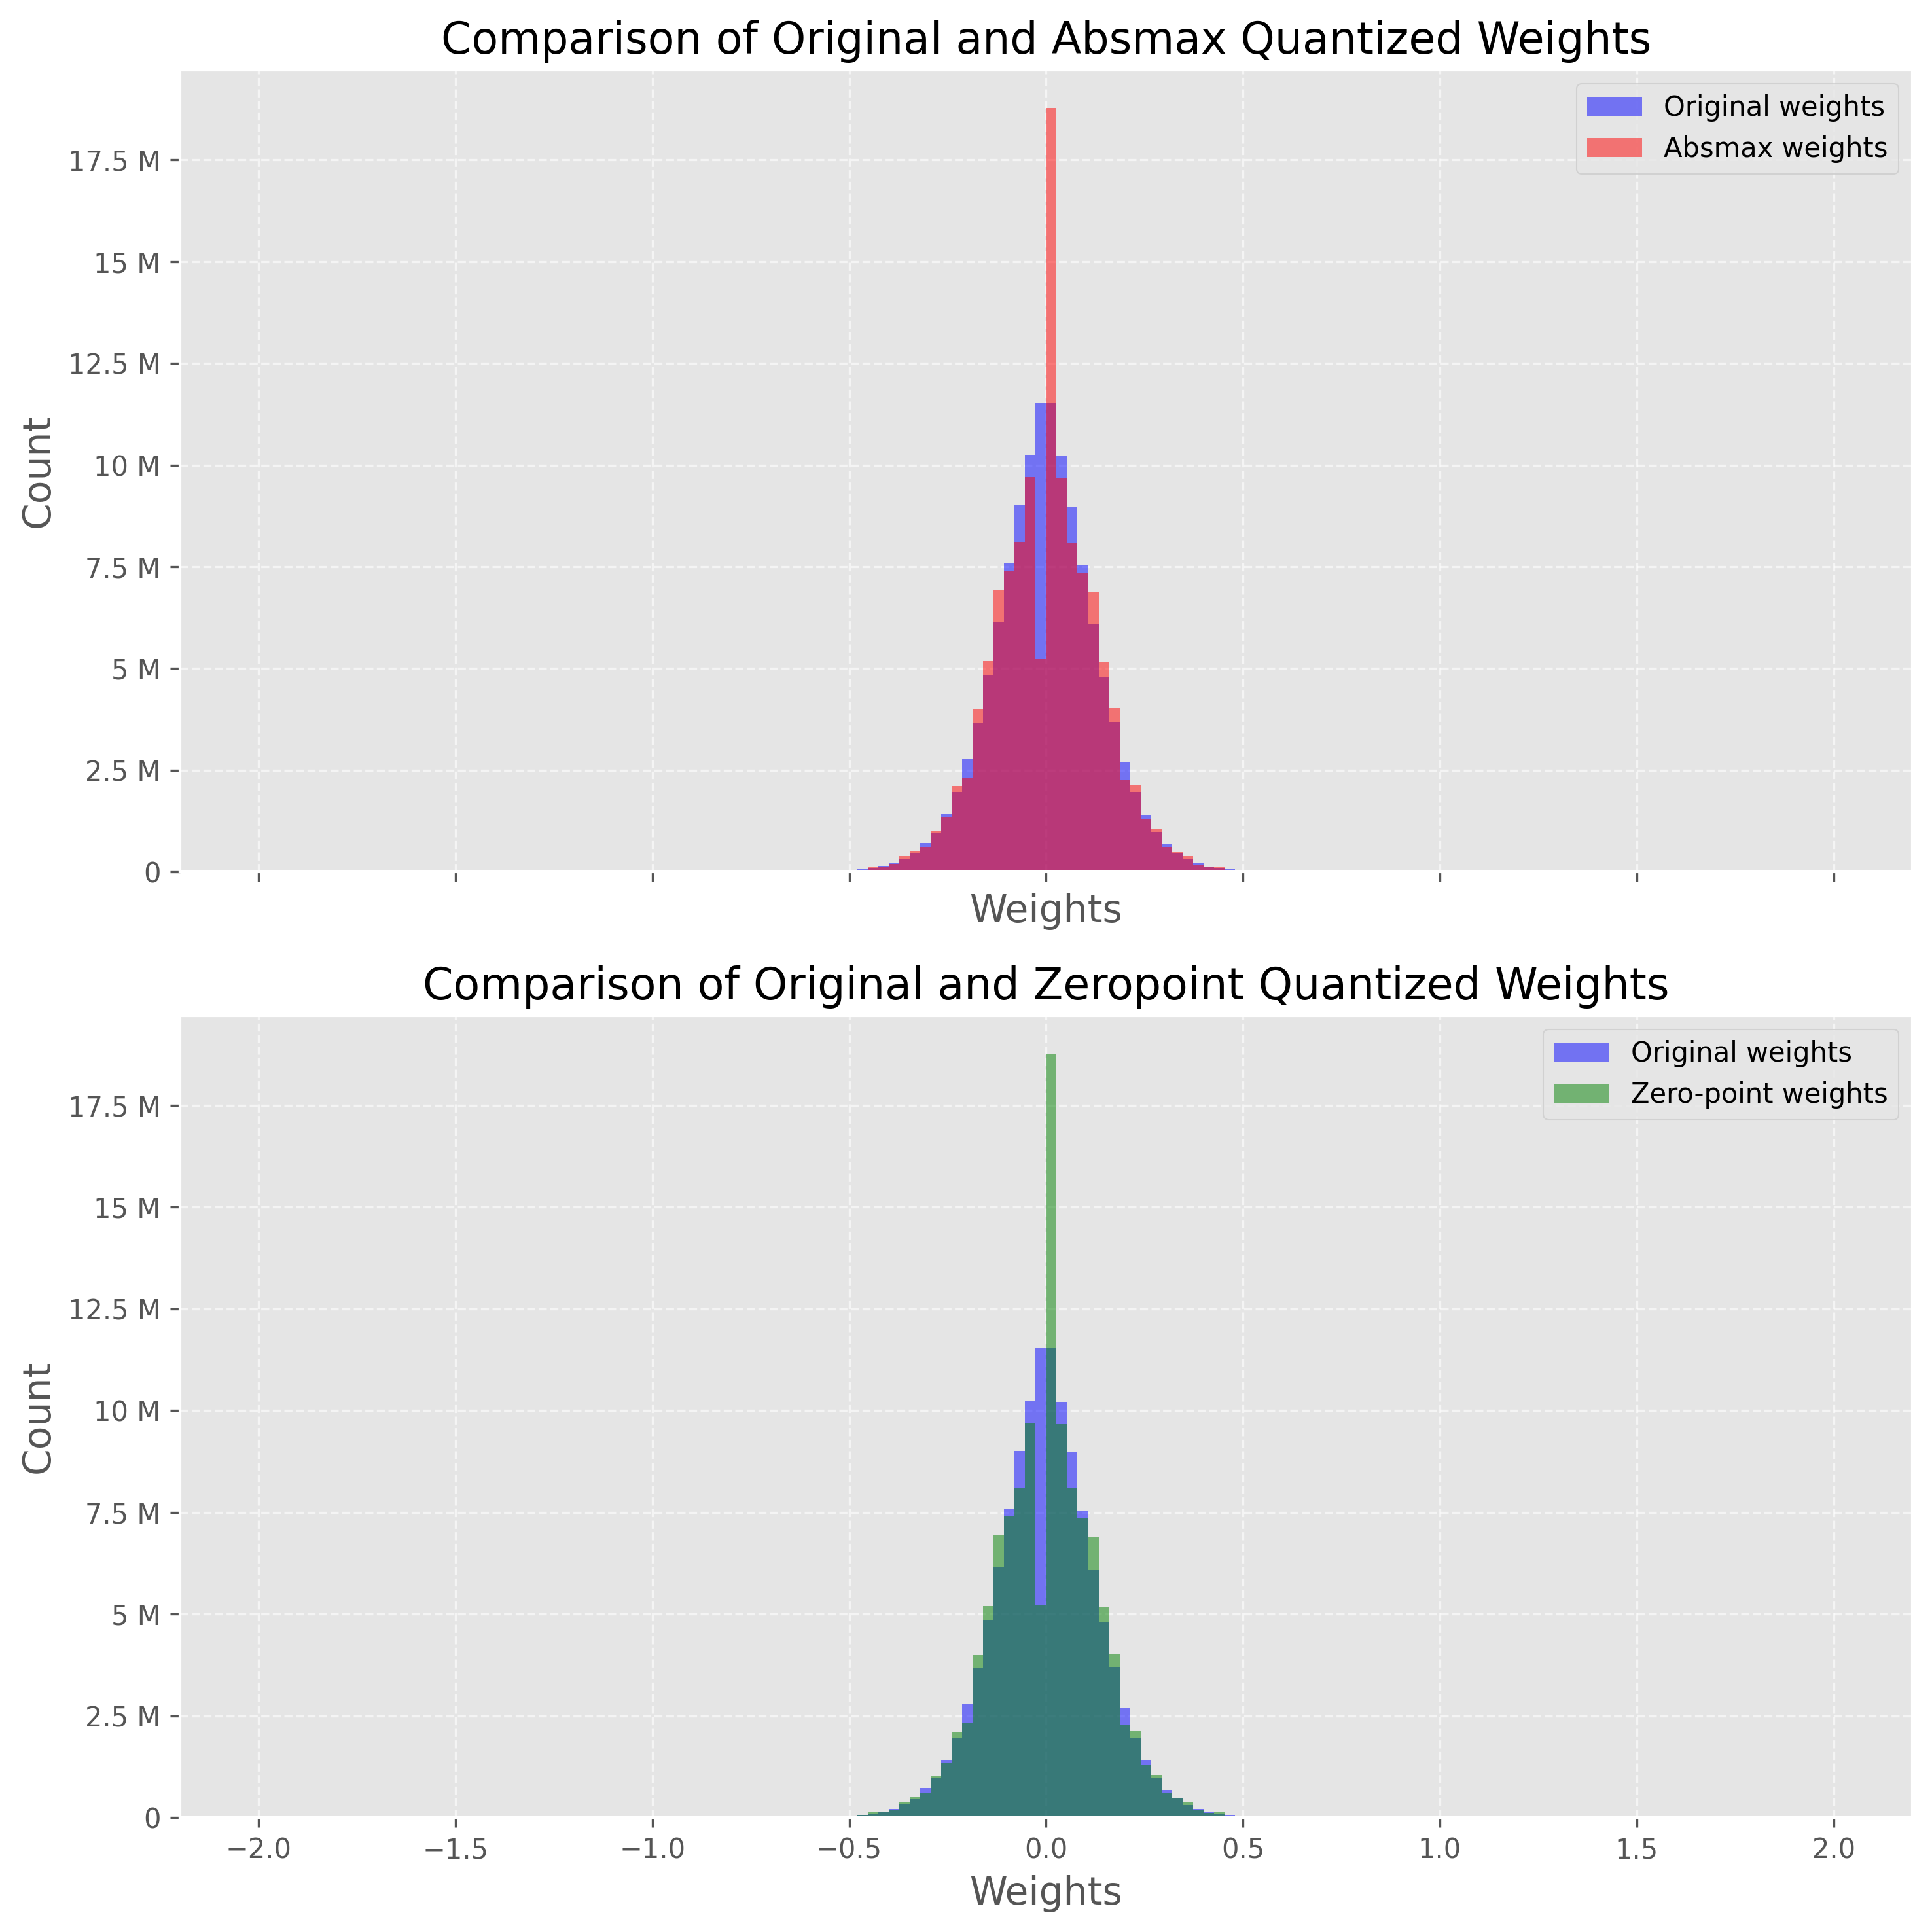

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

Both plots are quite similar, with a surprising spike around 0. This spike shows that our quantization is quite lossy since reversing the process doesn’t output the original values. This is particularly true for the absmax model, which displays both a lower valley and a higher spike around 0.

Let’s compare the performance of the original and quantized models. For this purpose, we define a generate_text() function to generate 50 tokens with top-k sampling.

In [47]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    output = model.generate(inputs=input_ids.to(device),
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape).to(device))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_abs, "I have a dream")
zp_text       = generate_text(model_zp, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream. I don't know what will come of it, but I am going to have to look for something that will be right. I haven't thought about it for a long time, but I have to try to get that thing
--------------------------------------------------
Absmax model:
I have a dream job.

If you can talk about your work and what you believe, then come on! I'm gonna love you!
--------------------------------------------------
Zeropoint model:
I have a dream. But I don't really think this is going anywhere," Trump told a group of reporters Monday at the United Kingdom's White House Correspondents' Dinner. 'If Russia wanted to interfere in American elections,' the president said. '


Instead of trying to see if one output makes more sense than the others, we can quantify it by calculating the perplexity of each output. This is a common metric used to evaluate language models, which measures the uncertainty of a model in predicting the next token in a sequence. In this comparison, we make the common assumption that the lower the score, the better the model is. In practice, a sentence with a high perplexity could also be correct.

We implement it using a minimal function since it doesn’t need to consider details like the length of the context window since our sentences are short.

In [49]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt')

    # Define input_ids and target_ids
    input_ids = encodings.input_ids.to(device)
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, absmax_text)

print(f"Original perplexity:  {ppl.item():.2f}")
print(f"Absmax perplexity:    {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity:  7.94
Absmax perplexity:    21.84
Zeropoint perplexity: 21.84


We see that the perplexity of the original model is slightly lower than the two others. A single experiment is not very reliable, but we could repeat this process multiple times to see the difference between each model. In theory, zero-point quantization should be slightly better than absmax, but is also more costly to compute.

In this example, we applied quantization techniques to entire layers (per-tensor basis). However, we could apply it at different granularity levels: from the entire model to individual values. Quantizing the entire model in one pass would seriously degrade the performance, while quantizing individual values would create a big overhead. In practice, we often prefer the vector-wise quantization, which considers the variability of values in rows and columns inside of the same tensor.

However, even vector-wise quantization doesn’t solve the problem of outlier features. Outlier features are extreme values (negative or positive) that appear in all transformer layers when the model reach a certain scale (>6.7B parameters). This is an issue since a single outlier can reduce the precision for all other values. But discarding these outlier features is not an option since it would greatly degrade the model’s performance.

# 8-bit Quantization with LLM.int8()

Introduced by Dettmers et al. (2022), LLM.int8() is a solution to the outlier problem. It relies on a vector-wise (absmax) quantization scheme and introduces mixed-precision quantization. This means that outlier features are processed in a FP16 format to retain their precision, while the other values are processed in an INT8 format. As outliers represent about 0.1% of values, this effectively reduces the memory footprint of the LLM by almost 2x.

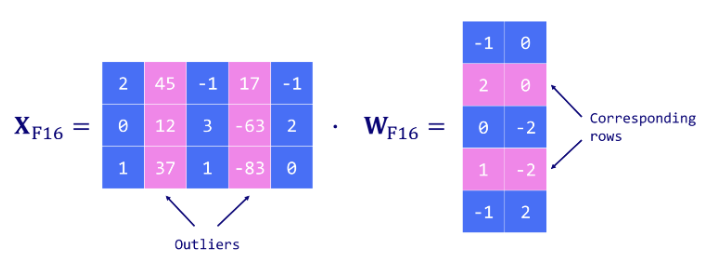

LLM.int8() works by conducting matrix multiplication computation in three key steps:

1. Extract columns from the input hidden states $\mathbf{X}$ containing outlier features using a custom threshold.
2. Perform the matrix multiplication of the outliers using FP16 and the non-outliers using INT8 with vector-wise quantization (row-wise for the hidden state $\mathbf{X}$ and column-wise for the weight matrix $\mathbf{W}$).
3. Dequantize the non-outlier results (INT8 to FP16) and add them to the outlier results to get the full result in FP16.

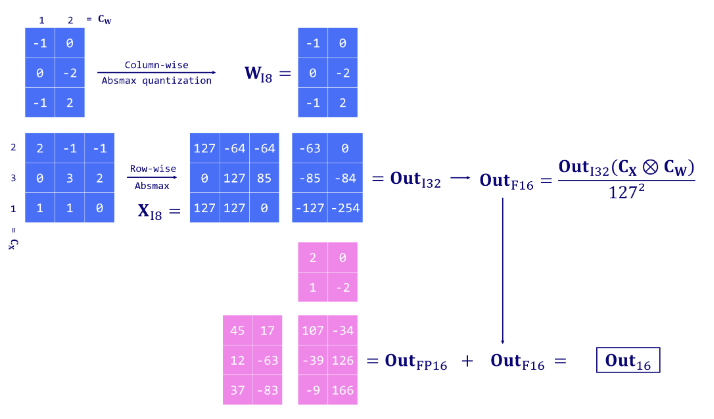

This approach is necessary because 8-bit precision is limited and can lead to substantial errors when quantizing a vector with large values. These errors also tend to amplify as they propagate through multiple layers.

We can easily use this technique thanks to the integration of the `bitsandbytes` library into the Hugging Face ecosystem. We just need to specify `load_in_8bit=True` when loading the model (it also requires a GPU).

In [50]:
model_int8 = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto', load_in_8bit=True)
print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Model size: 176,527,896 bytes


With this extra line of code, the model is now almost three times smaller (168MB vs. 487MB). We can even compare the distribution of the original and quantized weights as we did earlier:

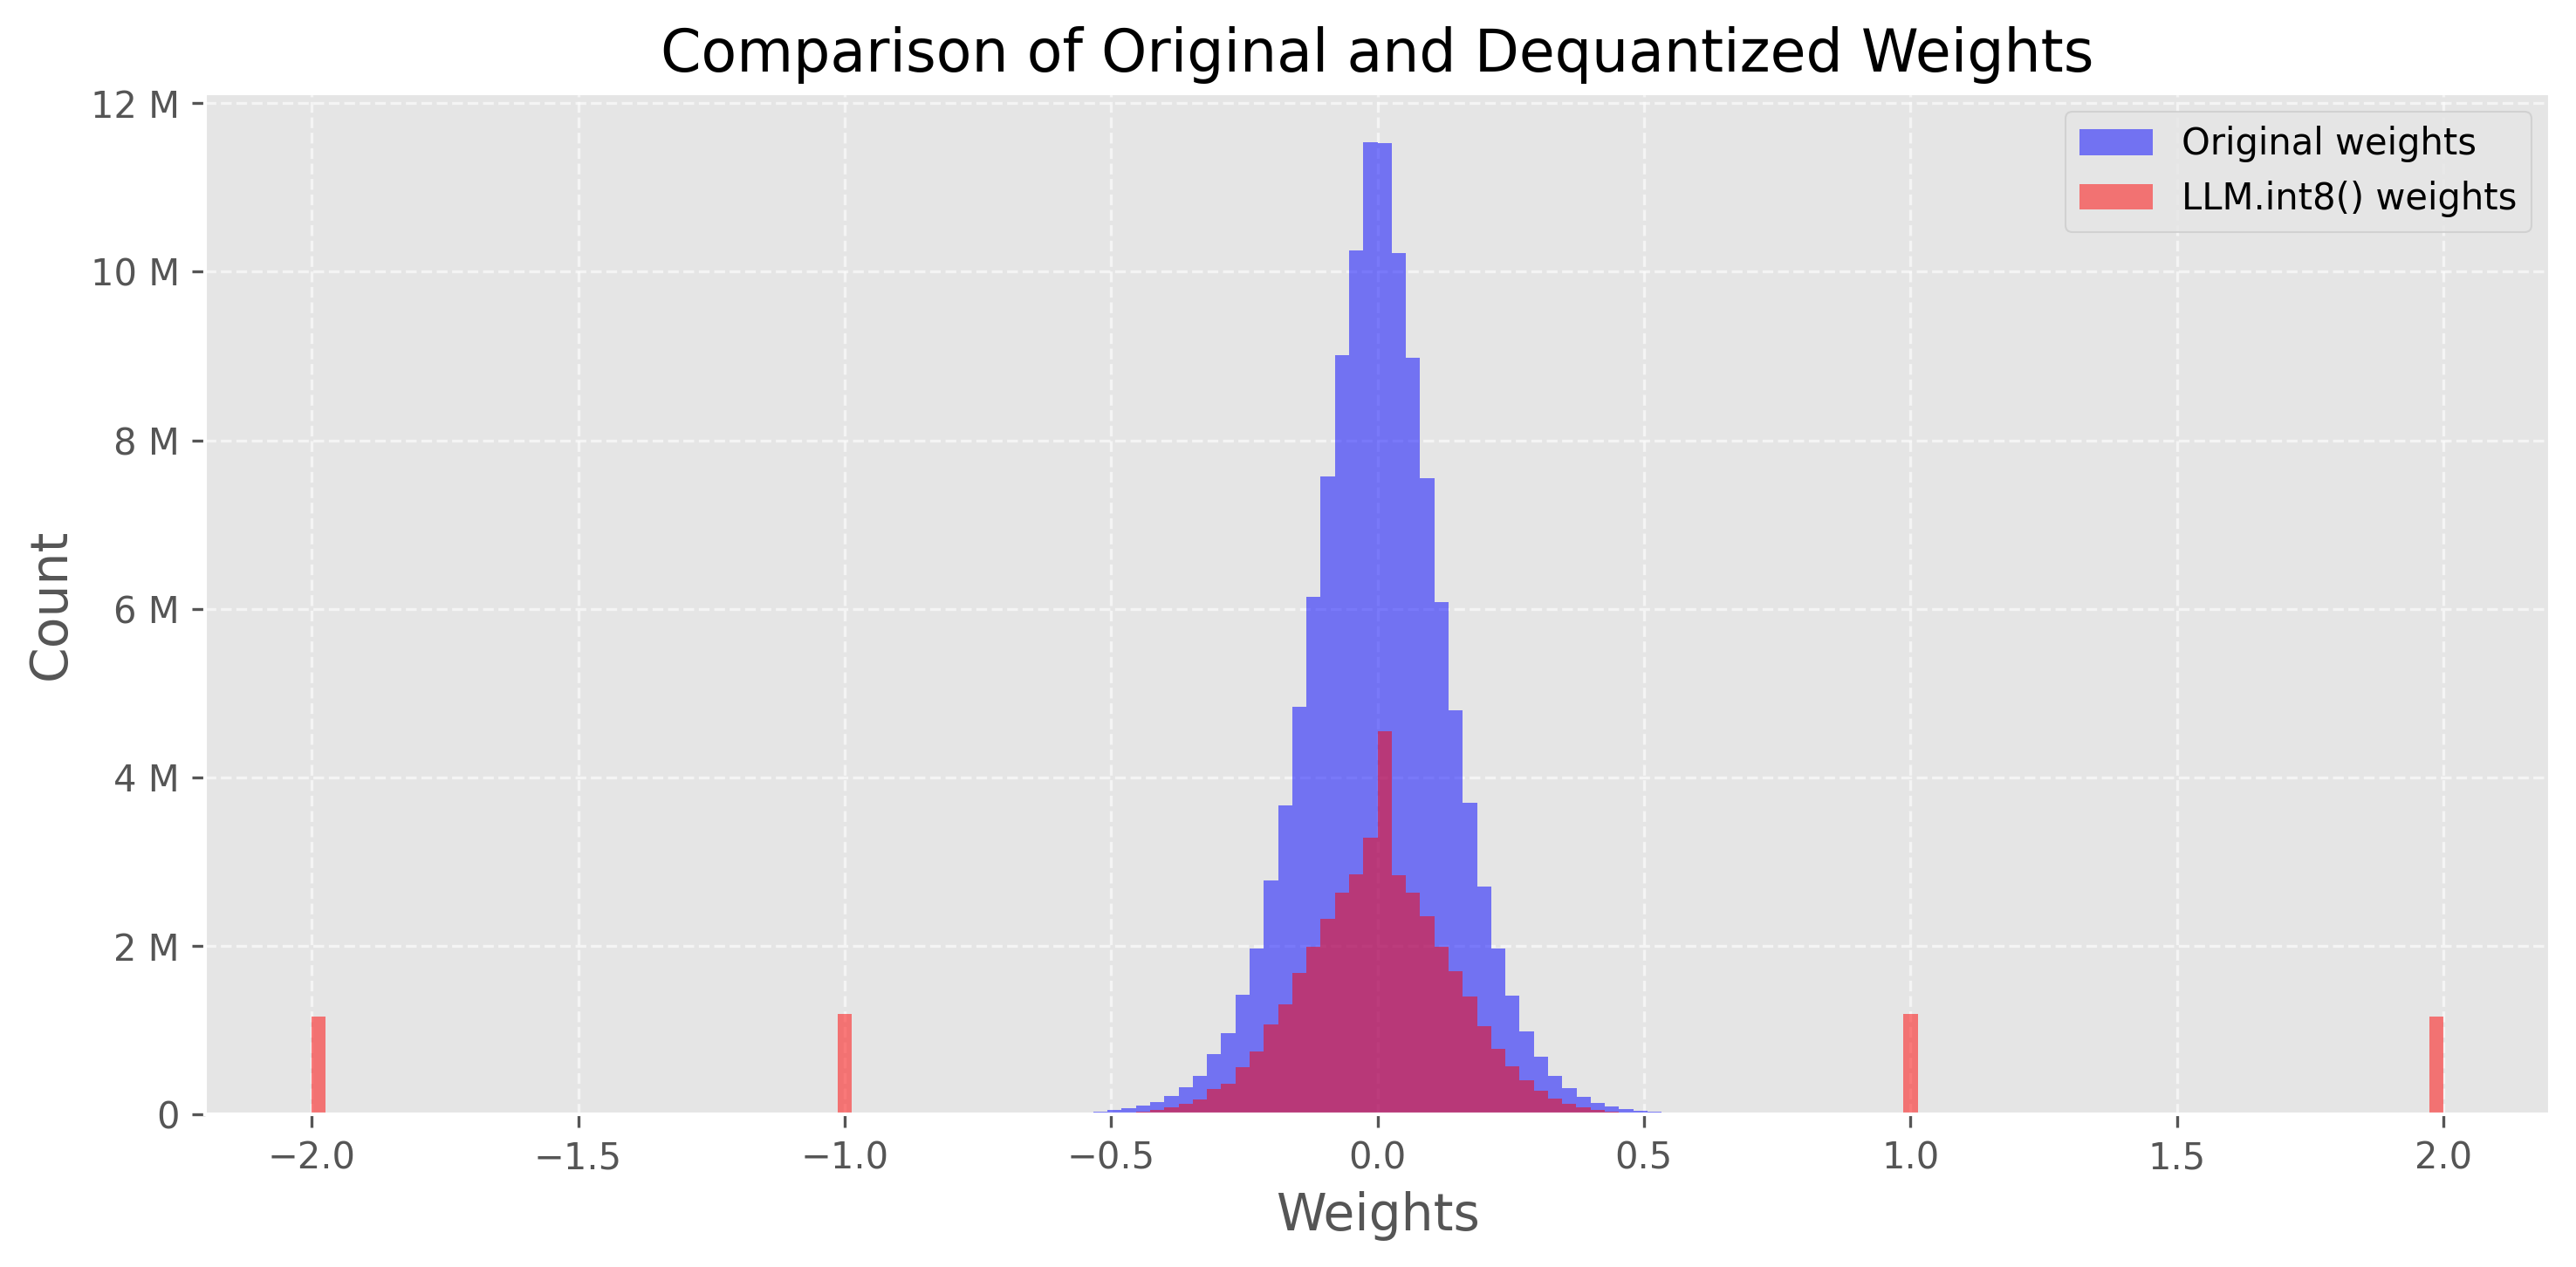

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights_int8 = [param.data.clone() for param in model_int8.parameters()]
weights_int8 = np.concatenate([t.cpu().numpy().flatten() for t in weights_int8])

# Set background style
plt.style.use('ggplot')

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

# Plot the histograms
ax.hist(weights, bins=150, alpha=0.5, label='Original weights',
        color='blue', range=(-2, 2))
ax.hist(weights_int8, bins=150, alpha=0.5, label='LLM.int8() weights',
        color='red', range=(-2, 2))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend()

# Add title and labels
ax.set_title('Comparison of Original and Dequantized Weights', fontsize=16)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

In this case, we see spikes around -2, -1, 0, 1, 2, etc. These values correspond to the parameters stored in the INT8 format (non-outliers). You can verify it by printing the model’s weights using `model_int8.parameters()`.

We can also generate text with this quantized model and compare it to the original model.

In [24]:
for param in model_int8.parameters():
    if param.dtype == torch.int8:
        print(param)
        break;

Parameter containing:
Parameter(Int8Params([[-65,  12,   1,  ..., -36,  21, -56],
            [-38,  21,  10,  ...,  -2,  31, -28],
            [-15,  36,  55,  ...,  30,  16, -36],
            ...,
            [ 20, -20,  44,  ...,   4,  11,  -2],
            [-37,  -7,  23,  ..., -33, -27,   4],
            [ 12,  -7, -15,  ...,  15, -22,   9]], device='cuda:0',
           dtype=torch.int8))


In [51]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

Original model:
I have a dream. I don't know what will come of it, but I am going to have to look for something that will be right. I haven't thought about it for a long time, but I have to try to get that thing
--------------------------------------------------
LLM.int8() model:
I have a dream to write a story that will inspire some people to do exactly that. I don't want to do that for myself, but I could do it to you, if you'd let me have that." So he said to the audience


In [52]:
print(f"Perplexity (original):   {ppl.item():.2f}")

ppl = calculate_perplexity(model_int8, text_int8)
print(f"Perplexity (LLM.int8()): {ppl.item():.2f}")

Perplexity (original):   7.94
Perplexity (LLM.int8()): 12.87


It shows that this quantization technique is very competitive. In fact, the authors of LLM.int8() show that the performance degradation is so low it’s negligible (<1%). However, it has an additional cost in terms of computation: LLM.int8() is roughly about 20% slower for large models.